## TP2 - Aprendizaje Automático

Francisco Javier Piqueras Martínez

Realizamos los imports:

In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow import keras
import matplotlib as mpl
import pandas as pd
import os
import matplotlib.pyplot as plt

Comprobamos versiones:

In [3]:
tf.__version__

'2.0.0'

In [4]:
keras.__version__

'2.2.4-tf'

Cargamos el dataset de MINST de keras.

In [5]:
MNIST_dataset = keras.datasets.mnist.load_data()

Dividimos en nuestro train set y test set

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = MNIST_dataset

In [7]:
X_train_full.shape

(60000, 28, 28)

In [8]:
X_train_full.dtype

dtype('uint8')

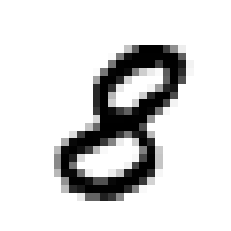

In [21]:
plt.imshow(X_train[5], cmap="binary")
plt.axis('off')
plt.show()

Primero separamos el validation set del training set y escalamos cada pixel al rango 0-1.

Puesto que cada pixel toma un valor entre 0 y 255, vamos a dividir por 255. 

Dividimos por 255 como float (con el '.') para que el resultado también tenga decimales

In [9]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [10]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

### Creación del modelo

Resolvemos el problema con una única MLP de 4 capas ocultas usando la API Secuencial.

- 28x28 = 784 input neurons.
- 4 capas opcultas.
- Neuronas por capa: 300, 200, 100 y 50
- 10 neuronas en la capa output

* Función de activación de las capas ocultas: ReLU
* Función de activación de la output layer: Softmax
* Loss Function: Cross Entropy

In [11]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 321,360
Trainable params: 321,360
Non-trainable params: 0
__________________________________________________

In [13]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 7s 128us/sample - loss: 0.6592 - accuracy: 0.8154 - val_loss: 0.2872 - val_accuracy: 0.9176
Epoch 2/100
55000/55000 [==============================] - 6s 117us/sample - loss: 0.2489 - accuracy: 0.9271 - val_loss: 0.2047 - val_accuracy: 0.9418
Epoch 3/100
55000/55000 [==============================] - 7s 121us/sample - loss: 0.1870 - accuracy: 0.9446 - val_loss: 0.1532 - val_accuracy: 0.9530
Epoch 4/100
55000/55000 [==============================] - 7s 120us/sample - loss: 0.1496 - accuracy: 0.9560 - val_loss: 0.1375 - val_accuracy: 0.9604
Epoch 5/100
55000/55000 [==============================] - 7s 121us/sample - loss: 0.1228 - accuracy: 0.9636 - val_loss: 0.1218 - val_accuracy: 0.9642
Epoch 6/100
55000/55000 [==============================] - 7s 120us/sample - loss: 0.1041 - accuracy: 0.9697 - val_loss: 0.1002 - val_accuracy: 0.9716
Epoch 7/100
55000/55000 [====================

Para solucionar un problema con MAC:

In [25]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Obtenemos un accuracy mayor del 97%.

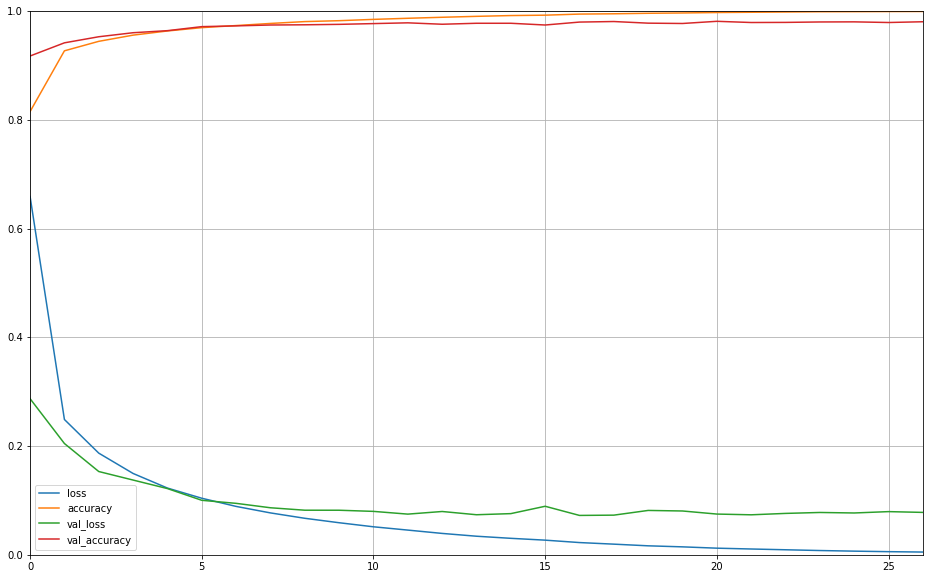

In [26]:
pd.DataFrame(history.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Evaluamos el modelo:

In [30]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[14.840407316708564, 0.9755]

Como podemos comprobar, obtenemos un accuracy mayor que el 97%.